# Восстановление золота из руды

Подготовьте прототип модели машинного обучения. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np # импорт библиотеки numpy
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
from sklearn.metrics import mean_absolute_error, make_scorer # импорт из библиотеки sklearn алгоритма make_scorer, mean_absolute_error
from sklearn.pipeline import make_pipeline # импорт из библиотеки sklearn алгоритма pipeline
from sklearn.preprocessing import StandardScaler # импорт из библиотеки sklearn алгоритма StandardScaler
from sklearn.linear_model import LinearRegression # импорт из библиотеки sklearn алгоритма линейной регрессии
from sklearn.tree import DecisionTreeRegressor # импорт из библиотеки sklearn алгоритма Дерева Решений
from sklearn.ensemble import RandomForestRegressor # импорт из библиотеки sklearn алгоритма Случайного Леса
from sklearn.model_selection import GridSearchCV # импорт из библиотеки sklearn алгоритма GridSearchCV
from sklearn.dummy import DummyRegressor # импорт из библиотеки sklearn алгоритма DummyRegressor
from catboost import CatBoostRegressor # импорт из библиотеки catboost алгоритма CatBoostRegressor

### Откройте файлы и изучите их.

In [2]:
# прочитаем файлы
train = pd.read_csv('***.csv')
test = pd.read_csv('***.csv')
full = pd.read_csv('***.csv')

In [3]:
# посмотрим на данные
print(train.info())
print(test.info())
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
# посмотрим на данные
print(train.shape)
print(test.shape)
print(full.shape)

(14149, 87)
(5290, 53)
(19439, 87)


В тестовой выборке не хватает столбцов. Подробнее об этом пункте "Анализ признаков, недоступных в тестовой выборке."

В данных присутствуют пропуски.

In [5]:
# сумма пропусков
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())
print(full.isnull().sum().sum())

4100
90
4481


In [6]:
# поиск дубликатов
print(train.duplicated().sum())
print(test.duplicated().sum())
print(full.duplicated().sum())

0
0
0


Дубликатов нет.

### Проверить, что эффективность обогащения рассчитана правильно.

In [7]:
# Функция расчета эффективности обогащения
def recovery(column):
    C = column['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки
    F = column['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки
    T = column['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки
    return (C*(F-T))/(F*(C-T))*100    

In [8]:
recovery(train).describe() # применение функции на тренировочной выборке, описание Series

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64

In [9]:
train['rougher.output.recovery'].describe() # описание признака rougher.output.recovery на тренировочной выборке

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [10]:
# MAE между расчётами и значением признака
print('MAE =', mean_absolute_error(recovery(train), train['rougher.output.recovery']))

MAE = 9.73512347450521e-15


**Вывод:**
Ошибка минимальна. Значит признак rougher.output.recovery посчитан верно. Можно идти дальше.

### Анализ признаков, недоступных в тестовой выборке.

In [11]:
pd.Series(train.columns.drop(test.columns)) # признаки, недоступные в тестовой выборке

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

- `rougher.calculation....` - расчётные характеристики флотации
- `rougher.output.concentrate...` - доля металла в концентрате после флотации
- `rougher.output.tail....` - параметры отвальных хвостов после флотации
- `rougher.output.recovery` - черновой концентрат после флотации
- `primary_cleaner.output.concentrate....` - доля металла в концентрате после первичной очистки
- `primary_cleaner.output.tail....` - параметры отвальных хвостов после первичной очистки
- `secondary_cleaner.output.tail....` - параметры отвальных хвостов после вторичной очистки
- `final.output.concentrate....` - доля металла в концентрате после вторичной очистки
- `final.output.tail....` - параметры отвальных хвостов после вторичной очистки
- `final.output.recovery` - финальный концентрат после вторичной очистки

**Вывод:**

Доли концентрации металлов на каждом этапе, отвальные хвосты на каждом этапе. А также 2 целевых признака.

Это признаки, которые напрямую влияют на прогноз целевого признака. Поэтому они отсутствуют в тестовой выборке, чтобы не допустить утечки целевого признака.

Так же их следует убрать из тренировочной выборки тоже.

### Предобработка данных.

#### Подготовка тренировочной выборки

Соседние по времени параметры часто похожи, так как это учебный проект и нет возможности запросить данные, пропуски можно заполнить соседними значениями.

In [12]:
train = train.fillna(method='ffill') # заполняем пропуски из предыдущей строки
features_train = train.drop(train.columns.drop(test.columns), axis =1) # удаляем столбцы, отсутствующие в тестовой выборке
features_train = features_train.set_index('date') # заменяем индексы датой

In [13]:
target_train_final = train['final.output.recovery'] # целевой признак тренировочной выборки
target_train_rougher = train['rougher.output.recovery'] # целевой признак тренировочной выборки

In [14]:
# проверка размеров тренировочной выборки
print(target_train_rougher.shape)
print(target_train_final.shape)
print(features_train.shape)

(14149,)
(14149,)
(14149, 52)


#### Подготовка тестовой выборки

In [15]:
test = test.fillna(method='ffill') # заполняем пропуски из предыдущей строки

In [16]:
# подтягивание целевого признака
test_merged = test.merge(full[['date','final.output.recovery','rougher.output.recovery']], on = 'date') 

In [17]:
test_merged = test_merged.set_index('date') # заменяем индексы датой
features_test = test_merged.drop(['final.output.recovery','rougher.output.recovery'],axis =1)  # удаляем целевые признаки

In [18]:
target_test_final = test_merged['final.output.recovery']  # целевой признак тестовой выборки
target_test_rougher = test_merged['rougher.output.recovery']  # целевой признак тестовой выборки

In [19]:
# проверка размеров тестовой выборки
print(target_test_rougher.shape)
print(target_test_final.shape)
print(features_test.shape)

(5290,)
(5290,)
(5290, 52)


In [20]:
full = full.fillna(method='ffill') # заполняем пропуски из предыдущей строки

**Выводы**

- Эффективность обогащения рассчитана правильно.
- Пропуски заполнены соседними значениями.
- Из тренировочной и тестовой выборок удалены столбцы, которые могли способствовать утечки целевого признака.
- Данные готовы для дальнейшего анализа и прогноза.

## Анализ данных

### Изучение изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

In [21]:
metal = {'Серебро':'ag','Свинец':'pb','Золото':'au'} # словарь металлов

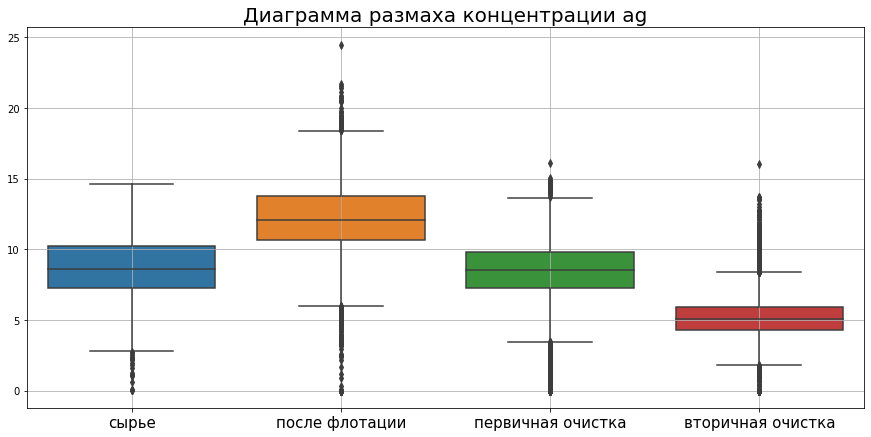

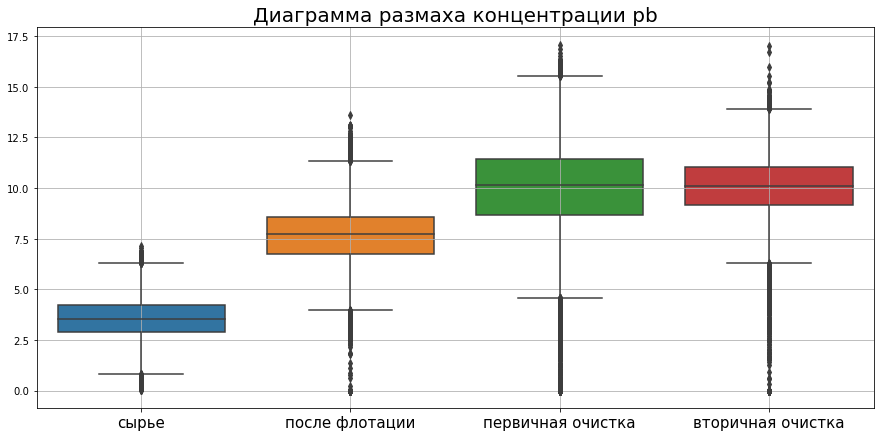

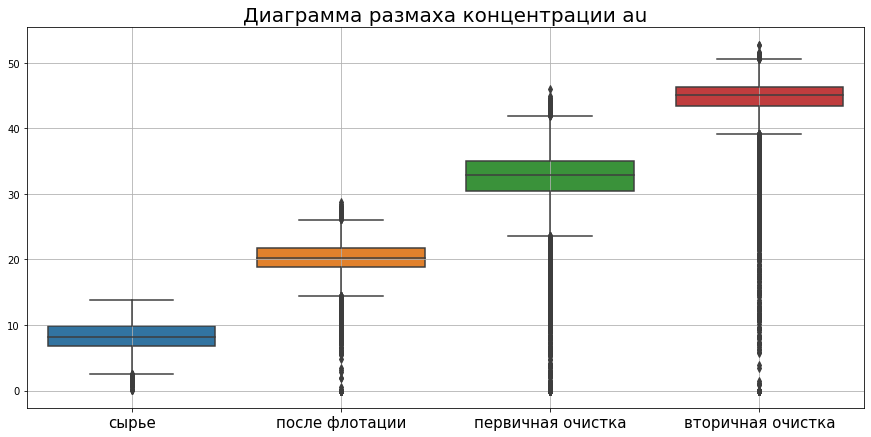

In [22]:
# цикл по металлам для построения диаграмм размаха концентрации металлов на различных этапах очистки
for i in metal:
    plt.figure(figsize=(15,7))
    plt.title('Диаграмма размаха концентрации ' + metal[i], fontsize = 20)
    sns.boxplot(data = full[['rougher.input.feed_' + metal[i],
                             'rougher.output.concentrate_' + metal[i],
                             'primary_cleaner.output.concentrate_' + metal[i],
                             'final.output.concentrate_' + metal[i]]])
    plt.xticks([0,1,2,3], ['сырье', 'после флотации', 'первичная очистка', 'вторичная очистка'], fontsize = 15)
    plt.grid()
plt.show()

Заметно растет концентрация золота в процессе очистки. Концентрация серебра падает. Концентрация свинца растет незначительно.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

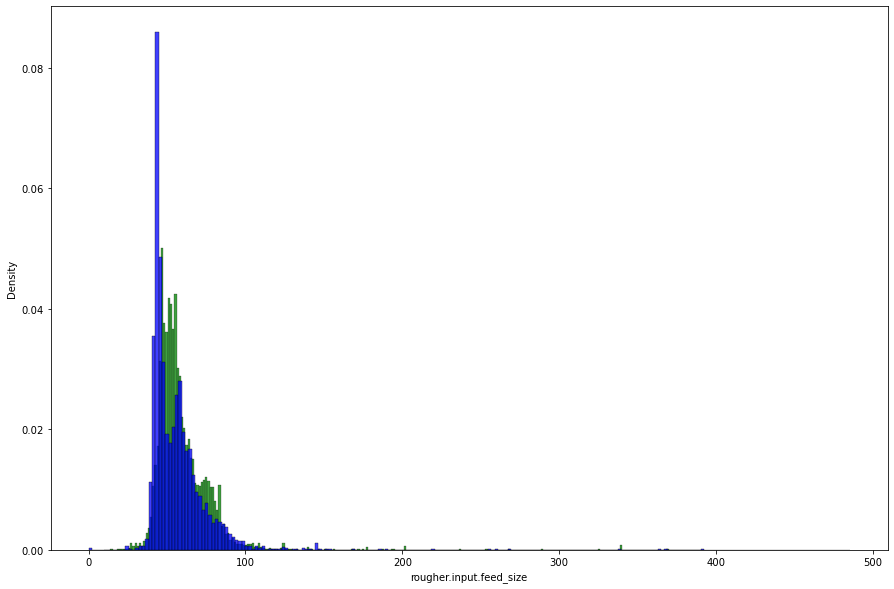

In [23]:
plt.figure(figsize=(15,10))
sns.histplot(train['rougher.input.feed_size'],stat="density", color = 'g');
# график распределения размеров гранул перед флорацией в тренировочной выборке
sns.histplot(test['rougher.input.feed_size'],stat="density", color = 'b');
# график распределения размеров гранул перед флорацией в тестовой выборке

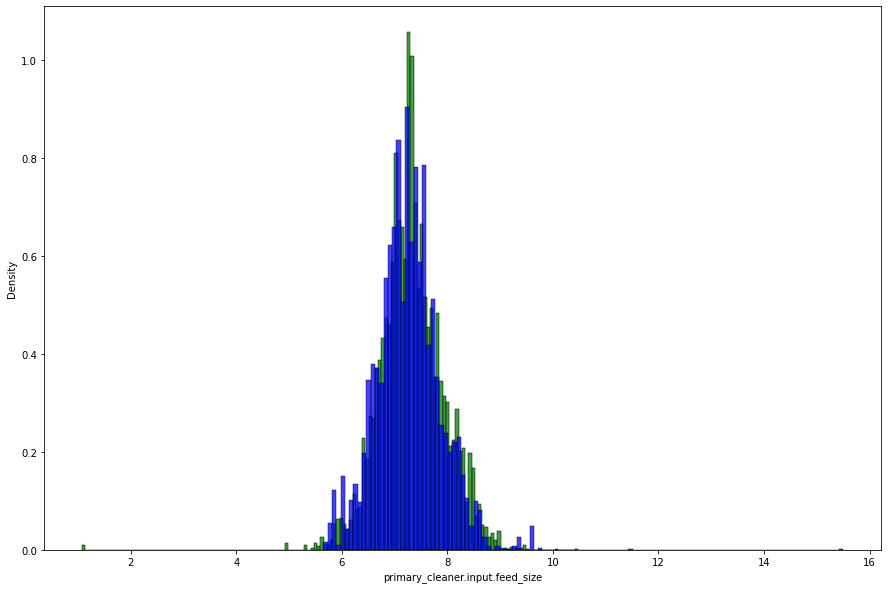

In [24]:
plt.figure(figsize=(15,10))
sns.histplot(train['primary_cleaner.input.feed_size'],stat="density", color = 'g');
# график распределения размеров гранул в финальном концентрате в тренировочной выборке
sns.histplot(test['primary_cleaner.input.feed_size'],stat="density", color = 'b');
# график распределения размеров гранул в финальном концентрате в тестовой выборке

Распределения размеров гранул сырья на обучающей и тестовой выборках очень похожи. Перед флотацией и финальный концентрат.
Оценки моделей должны быть правильными.

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [25]:
# суммируем концентрацию всех веществ на разных стадиях
rougher_input_feed = full[['rougher.input.feed_ag','rougher.input.feed_pb',
                           'rougher.input.feed_sol','rougher.input.feed_au']].T.sum()
rougher_output_concentrate = full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                                   'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].T.sum()
final_output_concentrate = full[['final.output.concentrate_ag','final.output.concentrate_pb',
                                 'final.output.concentrate_sol','final.output.concentrate_au']].T.sum()

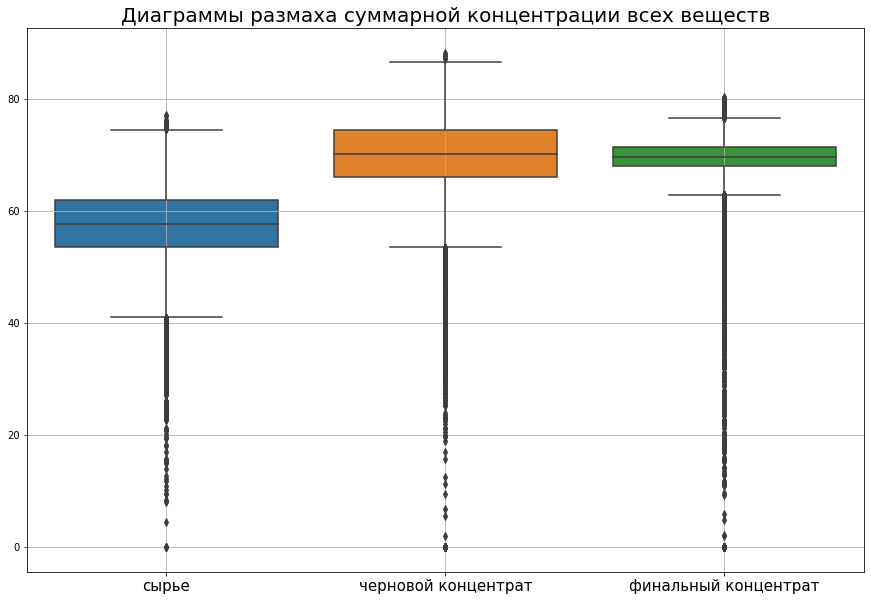

In [26]:
# диаграммы размаха суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
plt.figure(figsize=(15,10))
plt.title('Диаграммы размаха суммарной концентрации всех веществ', fontsize = 20)
sns.boxplot(data = [rougher_input_feed, rougher_output_concentrate, final_output_concentrate])
plt.xticks([0,1,2], ['сырье', 'черновой концентрат', 'финальный концентрат'], fontsize = 15)
plt.grid()
plt.show()

Концентрация веществ растет и сужается. Присутвствуют выбросы на минимальных значениях. Построим гистограмму, для просмотра выбросов.

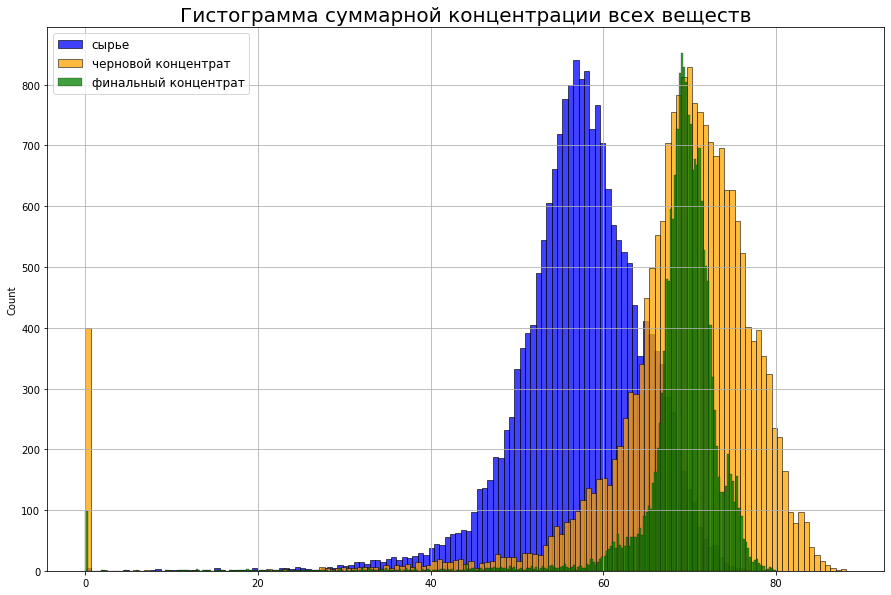

In [27]:
# строим гистограмму
plt.figure(figsize=(15,10))
plt.title('Гистограмма суммарной концентрации всех веществ', fontsize = 20)
sns.histplot(rougher_input_feed, color='blue')
sns.histplot(rougher_output_concentrate, color='orange')
sns.histplot(final_output_concentrate, color = 'green')
plt.legend(['сырье', 'черновой концентрат', 'финальный концентрат'], fontsize = 12)
plt.grid()
plt.show()

Очень много значений около 0 в черновом концентрате, а так же в финальном. Их лучше удалить, чтобы модель выстраивала предсказания правильней.

Это следует сделать на всех выборках, с последующей корректировкой признаков.

In [28]:
# удаление выбросов
full.query('`rougher.input.feed_ag` > 1 & `rougher.input.feed_pb` > 1 & \
            `rougher.input.feed_sol` > 1 & `rougher.input.feed_au` > 1 & \
            `rougher.output.concentrate_ag` > 1 & `rougher.output.concentrate_pb` > 1 & \
            `rougher.output.concentrate_sol` > 1 & `rougher.output.concentrate_au` > 1 & \
            `final.output.concentrate_ag` > 1 & `final.output.concentrate_pb` > 1 & \
            `final.output.concentrate_sol` > 1 & `final.output.concentrate_au` > 1', inplace = True)

In [29]:
# удаление выбросов
train.query('`rougher.input.feed_ag` > 1 & `rougher.input.feed_pb` > 1 & \
            `rougher.input.feed_sol` > 1 & `rougher.input.feed_au` > 1 & \
            `rougher.output.concentrate_ag` > 1 & `rougher.output.concentrate_pb` > 1 & \
            `rougher.output.concentrate_sol` > 1 & `rougher.output.concentrate_au` > 1 & \
            `final.output.concentrate_ag` > 1 & `final.output.concentrate_pb` > 1 & \
            `final.output.concentrate_sol` > 1 & `final.output.concentrate_au` > 1', inplace = True)

In [30]:
# удаление выбросов
test.query('`rougher.input.feed_ag` > 1 & `rougher.input.feed_pb` > 1 & \
            `rougher.input.feed_sol` > 1 & `rougher.input.feed_au` > 1', inplace = True)

In [31]:
# заново определяем переменные для проверки
rougher_input_feed = full[['rougher.input.feed_ag','rougher.input.feed_pb',
                           'rougher.input.feed_sol','rougher.input.feed_au']].T.sum()
rougher_output_concentrate = full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                                   'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].T.sum()
final_output_concentrate = full[['final.output.concentrate_ag','final.output.concentrate_pb',
                                 'final.output.concentrate_sol','final.output.concentrate_au']].T.sum()

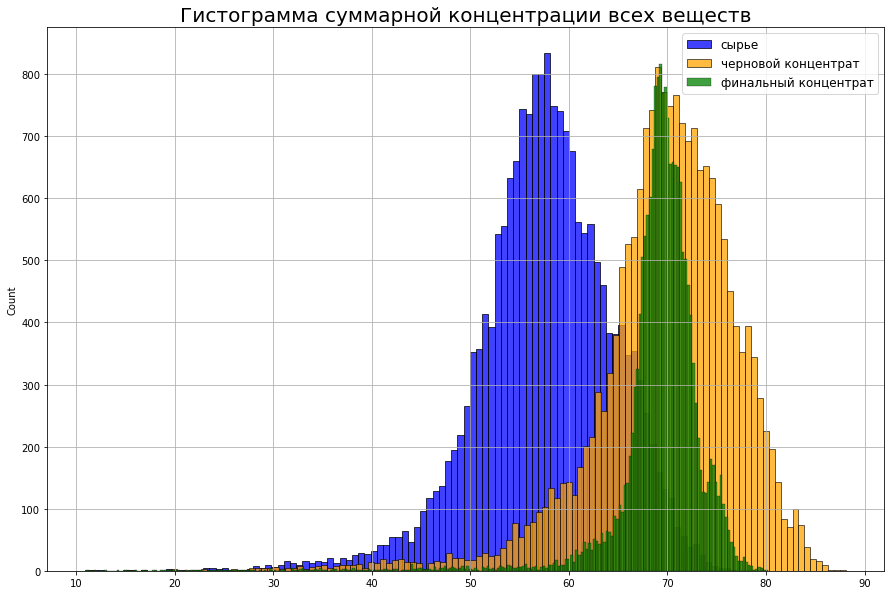

In [32]:
# строим гистограмму для проверки
plt.figure(figsize=(15,10))
plt.title('Гистограмма суммарной концентрации всех веществ', fontsize = 20)
sns.histplot(rougher_input_feed, color='blue')
sns.histplot(rougher_output_concentrate, color='orange')
sns.histplot(final_output_concentrate, color = 'green')
plt.legend(['сырье', 'черновой концентрат', 'финальный концентрат'], fontsize = 12)
plt.grid()
plt.show()

#### Корректировка признаков после удаления выбросов.

In [33]:
features_train = train.drop(train.columns.drop(test.columns), axis =1) # удаляем столбцы, отсутствующие в тестовой выборке
features_train = features_train.set_index('date') # заменяем индексы датой

In [34]:
target_train_final = train['final.output.recovery'] # целевой признак тренировочной выборки
target_train_rougher = train['rougher.output.recovery'] # целевой признак тренировочной выборки

In [35]:
# подтягивание целевого признака
test_merged = test.merge(full[['date','final.output.recovery','rougher.output.recovery']], on = 'date')

In [36]:
test_merged = test_merged.set_index('date') # заменяем индексы датой
features_test = test_merged.drop(['final.output.recovery','rougher.output.recovery'],axis =1) # удаляем целевые признаки

In [37]:
target_test_final = test_merged['final.output.recovery'] # целевой признак тестовой выборки
target_test_rougher = test_merged['rougher.output.recovery'] # целевой признак тестовой выборки

In [38]:
# проверка размеров тренировочной выборки
print(target_train_rougher.shape)
print(target_train_final.shape)
print(features_train.shape)

(13542,)
(13542,)
(13542, 52)


In [39]:
# проверка размеров тестовой выборки
print(target_test_rougher.shape)
print(target_test_final.shape)
print(features_test.shape)

(5138,)
(5138,)
(5138, 52)


**Вывод**

- Концентрация золота растет от первичного сырья к финальной очистке.
- Распределения размеров гранул сырья на обучающей и тестовой выборках почти совпадают.
- Удалены выбросы во всех выборках для корректного обучения моделей.
- Проведены корректировки признаков после удаления выбросов.

## Модель

### Запись функции для вычисления итоговой sMAPE.

In [40]:
# sMAPE (Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)
def sMAPE(target, predict):
    return np.mean(abs(target - predict)/((abs(target)+abs(predict))/2))*100

In [41]:
# итоговая sMAPE
def final_sMAPE(rougher, final):
    return (0.25*rougher + 0.75*final)

### Обучение разных моделей и оценка качество кросс-валидацией. Выбор лучшей модели и проверка на тестовой выборке.

In [42]:
custom_score = make_scorer(sMAPE, greater_is_better=False) # создание собственной метрики

In [43]:
model_lr = make_pipeline(StandardScaler(), LinearRegression()) # pipeline для масштабирования и Линейной Регрессии 
model_dt = make_pipeline(DecisionTreeRegressor()) 
model_rf = make_pipeline(RandomForestRegressor()) 
model_cb = make_pipeline(CatBoostRegressor()) 

In [44]:
# подбор гиперпараметров для моделей (оставлены лучшие параметры)
grid_lr= {}
grid_dt= {'decisiontreeregressor__max_depth':[2,3],
          'decisiontreeregressor__random_state':[42]}
grid_rf = {'randomforestregressor__n_estimators':[40,95],
           'randomforestregressor__max_depth':[4],
           'randomforestregressor__random_state':[42],
           'randomforestregressor__n_jobs':[-1]}
grid_cb = {'catboostregressor__n_estimators':[7],
           'catboostregressor__max_depth':[3],
           'catboostregressor__random_state':[42]}

In [45]:
# кросс-валидация и поиск лучших параметров для моделей
lr_rougher = GridSearchCV(model_lr, param_grid=grid_lr, cv= 5, scoring = custom_score)
lr_final = GridSearchCV(model_lr, param_grid=grid_lr, cv= 5, scoring = custom_score)
dt_rougher = GridSearchCV(model_dt, param_grid=grid_dt, cv= 5, scoring = custom_score)
dt_final = GridSearchCV(model_dt, param_grid=grid_dt, cv= 5, scoring = custom_score)
rf_rougher = GridSearchCV(model_rf, param_grid=grid_rf, cv= 5, scoring = custom_score)
rf_final = GridSearchCV(model_rf, param_grid=grid_rf, cv= 5, scoring = custom_score)
cb_rougher = GridSearchCV(model_cb, param_grid=grid_cb, cv= 5, scoring = custom_score)
cb_final = GridSearchCV(model_cb, param_grid=grid_cb, cv= 5, scoring = custom_score)

In [46]:
# обучение моделей
lr_rougher.fit(features_train,target_train_rougher)
lr_final.fit(features_train,target_train_final)
dt_rougher.fit(features_train,target_train_rougher)
dt_final.fit(features_train,target_train_final)
rf_rougher.fit(features_train,target_train_rougher)
rf_final.fit(features_train,target_train_final)
cb_rougher.fit(features_train,target_train_rougher)
cb_final.fit(features_train,target_train_final)

Learning rate set to 0.5
0:	learn: 5.8454166	total: 161ms	remaining: 964ms
1:	learn: 5.2860187	total: 172ms	remaining: 429ms
2:	learn: 4.9764647	total: 183ms	remaining: 244ms
3:	learn: 4.8206418	total: 200ms	remaining: 150ms
4:	learn: 4.6958717	total: 211ms	remaining: 84.5ms
5:	learn: 4.5883434	total: 218ms	remaining: 36.4ms
6:	learn: 4.5172478	total: 223ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 6.5649228	total: 3.03ms	remaining: 18.2ms
1:	learn: 5.8752793	total: 5.84ms	remaining: 14.6ms
2:	learn: 5.4967688	total: 8.42ms	remaining: 11.2ms
3:	learn: 5.3577725	total: 10.9ms	remaining: 8.16ms
4:	learn: 5.1856592	total: 13.5ms	remaining: 5.39ms
5:	learn: 5.0443535	total: 15.9ms	remaining: 2.65ms
6:	learn: 4.9637527	total: 18.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 6.8908886	total: 3.16ms	remaining: 19ms
1:	learn: 6.0737768	total: 5.89ms	remaining: 14.7ms
2:	learn: 5.7356439	total: 8.59ms	remaining: 11.5ms
3:	learn: 5.5392355	total: 11.2ms	remaining: 8.36ms
4:	learn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x0000019375425AC0>)]),
             param_grid={'catboostregressor__max_depth': [3],
                         'catboostregressor__n_estimators': [7],
                         'catboostregressor__random_state': [42]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [47]:
# вывод лучших гиперпараметров моделей
lr_rougher.best_estimator_
lr_final.best_estimator_
print(dt_rougher.best_estimator_)
print(dt_final.best_estimator_)
print(rf_rougher.best_estimator_)
print(rf_final.best_estimator_)
print(cb_rougher.best_estimator_)
print(cb_final.best_estimator_)

Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])
Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=2, random_state=42))])
Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=4, n_estimators=40, n_jobs=-1,
                                       random_state=42))])
Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=4, n_estimators=95, n_jobs=-1,
                                       random_state=42))])
Pipeline(steps=[('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x0000019373A68A00>)])
Pipeline(steps=[('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x00000193754A29D0>)])


In [48]:
print('Лучшая итоговая sMAPE Линейной Регрессии:', final_sMAPE(lr_rougher.best_score_, lr_final.best_score_))
print('Лучшая итоговая sMAPE Дерева Решений:', final_sMAPE(dt_rougher.best_score_, dt_final.best_score_))
print('Лучшая итоговая sMAPE Случайного Леса:', final_sMAPE(rf_rougher.best_score_, rf_final.best_score_))
print('Лучшая итоговая sMAPE CatBoost:', final_sMAPE(cb_rougher.best_score_, cb_final.best_score_))

Лучшая итоговая sMAPE Линейной Регрессии: -9.898897315641191
Лучшая итоговая sMAPE Дерева Решений: -8.602463991220798
Лучшая итоговая sMAPE Случайного Леса: -8.185140591850393
Лучшая итоговая sMAPE CatBoost: -8.045681611167415


Лучшая модель: CatBoost.

**Проверка на тестовой выборке:**

In [49]:
# подсчет sMAPE на тестовой выборке
test_lr_rougher = sMAPE(target_test_rougher, lr_rougher.predict(features_test))
test_lr_final = sMAPE(target_test_final, lr_final.predict(features_test))

test_dt_rougher = sMAPE(target_test_rougher, dt_rougher.predict(features_test))
test_dt_final = sMAPE(target_test_final, dt_final.predict(features_test))

test_rf_rougher = sMAPE(target_test_rougher, rf_rougher.predict(features_test))
test_rf_final = sMAPE(target_test_final, rf_final.predict(features_test))

test_cb_rougher = sMAPE(target_test_rougher, cb_rougher.predict(features_test))
test_cb_final = sMAPE(target_test_final, cb_final.predict(features_test))

In [50]:
print('Лучшая итоговая sMAPE Линейной Регрессии:', final_sMAPE(test_lr_rougher, test_lr_final))
print('Лучшая итоговая sMAPE Дерева Решений:', final_sMAPE(test_dt_rougher, test_dt_final))
print('Лучшая итоговая sMAPE Случайного Леса:', final_sMAPE(test_rf_rougher, test_rf_final))
print('Лучшая итоговая sMAPE CatBoost:', final_sMAPE(test_cb_rougher, test_cb_final))

Лучшая итоговая sMAPE Линейной Регрессии: 7.439705235137494
Лучшая итоговая sMAPE Дерева Решений: 7.4924524614914105
Лучшая итоговая sMAPE Случайного Леса: 7.328726568656651
Лучшая итоговая sMAPE CatBoost: 6.439484351577626


**Проверка модели на адекватность:**

In [51]:
# вызов константной модели
dummy = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

In [52]:
# обучение модели
dummy.fit(features_train,target_train_rougher)
dummy_final.fit(features_train,target_train_final)

DummyRegressor()

In [53]:
# предсказания модели
dummy_rougher = dummy.predict(features_test)
dummy_final = dummy_final.predict(features_test)

In [54]:
print('Итоговая sMAPE Константной Модели:',
       final_sMAPE(sMAPE(target_test_rougher,dummy_rougher),sMAPE(target_test_final,dummy_final)))

Итоговая sMAPE Константной Модели: 7.606136126514113


**Выводы:**

- Были обучены 4 модели с использованием кросс-валидации
- В качестве метрики была использована формула sMAPE с помощью make_scorer
- Лучшая модель: CatBoost. Со значением -8.046 на тренировочной и 6.44 на тестовой выборке.
- Все модели прошли тест на адекватность. Значения метрик меньше константной модели.